# Task 2: Modeling Water Flow on the Sphere with FNO

The purpose of this exercise is to model water flow,training a Spherical Fourier-Neural Operator.

To make it possible, we completed the following steps:

1) **SFNO Implementation:** We developed an implementation of SFNO specifically tailored for solving the Shallow Water Equations.

2) **Dataset Creation and Loading:** For dataset creation and loading, we utilized pre-existing code and employed the `load_spherical_swe` function from [this link](https://neuraloperator.github.io/neuraloperator/dev/auto_examples/plot_SFNO_swe.html).

3) **Restricted Package Usage:** While developing our implementation, we refrained from using the SFNO implementation available in the provided package. Instead, we utilized the dataset utilities.

4) **Spherical Convolutional Layer:** We implemented the required specialized convolutional layer for SFNO using the RealSHT and InverseRealSHT modules from [this repository](https://github.com/NVIDIA/torch-harmonics).

5) **Resolution Experimentation:** Experimentation involved training SFNO on datasets at different resolutions, starting with (32, 64). We compared the results with those obtained from a baseline neural operator trained on the same dataset but without considering the spherical geometry.

6) **Baseline Implementation:** For the baseline neural operator, we explored existing code available online and performed the training ourselves using the provided dataset.


## Install Packages

In [99]:
# basic imports for a Fourier Neural Operator
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam, AdamW
from neuralop.datasets import load_spherical_swe
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from torch_harmonics import *

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [100]:
def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['lrelu', 'LReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus(beta=4)
    elif name in ['celu', 'CeLU']:
        return nn.CELU()
    elif name in ['elu']:
        return nn.ELU()
    elif name in ['mish']:
        return nn.Mish()
    else:
        raise ValueError('Unknown activation function')

MPS is a framework provided by Apple for high-performance graphics and data-parallel computation on macOS and iOS devices. When you set the device to 'mps', you're indicating that you want to utilize Apple's GPUs for your computations, leveraging the MPS framework to accelerate operations.

In [101]:
# Loading the Navier-Stokes dataset in 128x128 resolution

train_loader, test_loaders = load_spherical_swe(
    n_train=200,
    batch_size=4,
    train_resolution=(32, 64),
    test_resolutions=[(32, 64), (64, 128)],
    n_tests=[50, 50],
    test_batch_sizes=[10, 10],
)

## divide the dataloaders for the two resolutions
test_loader_32_64 = test_loaders[(32, 64)]
test_loader_64_128 = test_loaders[(64, 128)]

Loading train dataloader at resolution (32, 64) with 200 samples and batch-size=4
Loading test dataloader at resolution (32, 64) with 50 samples and batch-size=10
Loading test dataloader at resolution (64, 128) with 50 samples and batch-size=10


It’s possible to see the training and test datasets. The training dataset has 200 samples, while the test dataset has 50 samples. The test dataloader has two resolutions, (32, 64) and (64, 128). The batch size is 4 for the training dataset and 10 for the test dataset.

Compared to the tutorial obtained on the internet, it wasn’t possible to use SFNO and FNO as way to study the dataset. For this reason, we have to implement it by ourselves. To make it possible, we can use the tutorial on Moodle apart from other similar implementations.

In [102]:
test_loader_32_64, test_loader_64_128

(<torch.utils.data.dataloader.DataLoader at 0x34b7ec410>,
 <torch.utils.data.dataloader.DataLoader at 0x34b7ed950>)

Using this approach it's possible from our side to use two different test loaders. In this case, we divided them properly to have the two different resolutions and to improve the code readability.

In [103]:
# Get a single batch from the DataLoader
batch = next(iter(test_loader_32_64))

# Check the shape of the data in the batch
print("Shape of input data:", batch['x'].shape)
print("Shape of target data:", batch['y'].shape)

Shape of input data: torch.Size([10, 3, 32, 64])
Shape of target data: torch.Size([10, 3, 32, 64])


## Data Exploration and preprocessing

In [104]:
batch = next(iter(train_loader))

In [105]:
# Print the keys of the dictionary
print("Keys in the batch:", batch.keys())

Keys in the batch: dict_keys(['x', 'y'])


In [106]:
# Inspect the values
for key in batch:
    print(f"Key: {key}, Value shape: {batch[key].shape}, Value type: {type(batch[key])}")

Key: x, Value shape: torch.Size([4, 3, 32, 64]), Value type: <class 'torch.Tensor'>
Key: y, Value shape: torch.Size([4, 3, 32, 64]), Value type: <class 'torch.Tensor'>


In this case it's possible to see there are `x` and `y` values. Those would represent the input and the target images. We would like to have a horizontal frame that can be wider than the vertical one. For this reason, we can see that we have that both the input and the target images are in the format `(batch_size,channels,n_lat,n_long)`

In this case we could see how the values of our input and target images are distributed. We can see that the values are in the range of 0 to 1. This is a good thing because it means that the data is already normalized.

In [107]:
# print the min and max values of the input for the first batch (this is for x)
print("Min and max values of the input for the first batch (this is for x)")
for i in range(batch['x'].shape[1]):
    print(f"Min value of channel {i}: {torch.min(batch['x'][0, i, :, :])}, Max value of channel {i}: {torch.max(batch['x'][0, i, :, :])}")

# print the min and max values of the input for the first batch (this is for y)
print("Min and max values of the input for the first batch (this is for y)")
for i in range(batch['y'].shape[1]):
    print(f"Min value of channel {i}: {torch.min(batch['y'][0, i, :, :])}, Max value of channel {i}: {torch.max(batch['y'][0, i, :, :])}")

Min and max values of the input for the first batch (this is for x)
Min value of channel 0: -3.6461424827575684, Max value of channel 0: 2.991144895553589
Min value of channel 1: -2.9435291290283203, Max value of channel 1: 3.0824670791625977
Min value of channel 2: -2.8056256771087646, Max value of channel 2: 2.754511833190918
Min and max values of the input for the first batch (this is for y)
Min value of channel 0: -5.248349666595459, Max value of channel 0: 6.004298686981201
Min value of channel 1: -2.48325777053833, Max value of channel 1: 2.5082943439483643
Min value of channel 2: -2.0338873863220215, Max value of channel 2: 2.0156304836273193


The format of the channels is weird because is not in a standard format for images.

### Plot the data

It's possible to plot the data for x and y. In this case, we can see that the data is in the format `(batch_size,channels,n_lat,n_long)`. We can see that the data is in the format of a sphere. The data is in the format of a sphere, with the first channel representing the normalized RGB values and the other two channels representing the latitude and longitude.

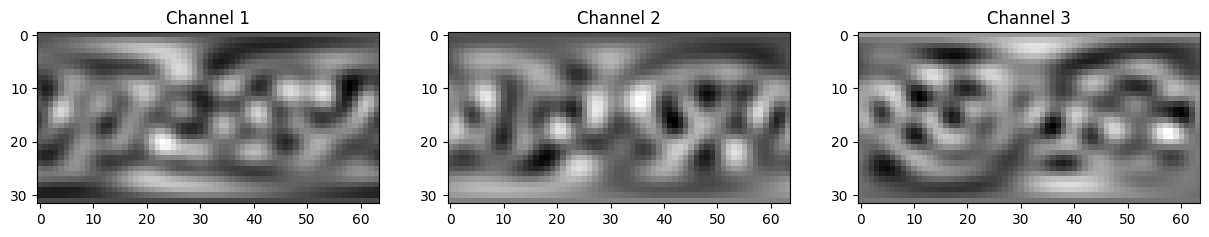

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


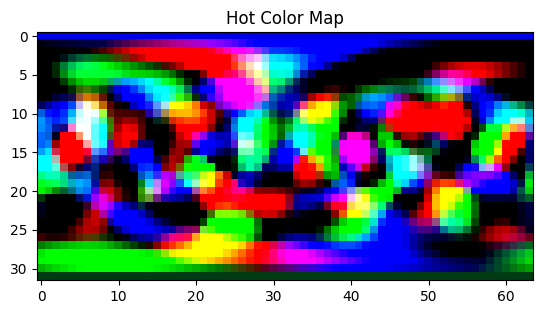

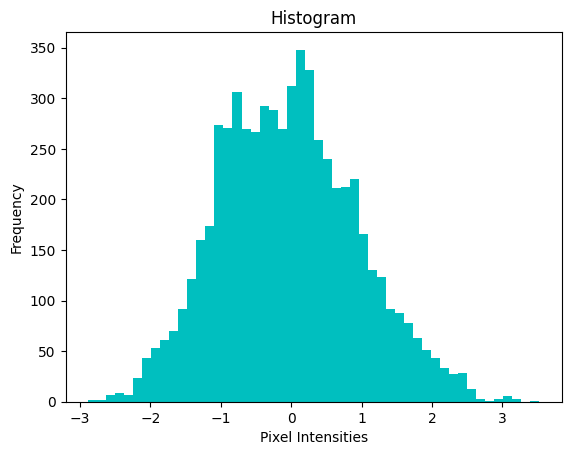

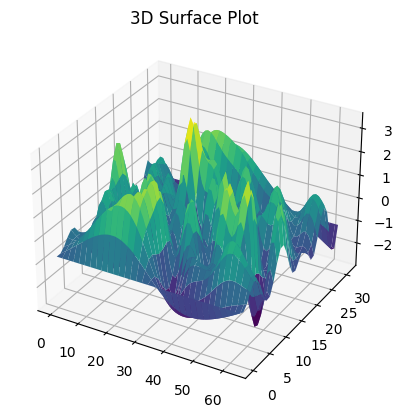

In [108]:
# Analysing the x values

first_datum = batch['x'][3,:,:,:]

# Separate Channel Visualization
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axs[i].imshow(first_datum[i, :, :], cmap='gray')
    axs[i].set_title(f'Channel {i+1}')
plt.show()

# Color Mapping
plt.imshow(first_datum.permute(1, 2, 0), cmap='hot')
plt.title('Hot Color Map')
plt.show()

# Histogram
plt.hist(first_datum.flatten(), bins=50, color='c')
plt.title('Histogram')
plt.xlabel('Pixel Intensities')
plt.ylabel('Frequency')
plt.show()

# 3D Surface Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(0, first_datum.shape[2]-1, first_datum.shape[2])
y = np.linspace(0, first_datum.shape[1]-1, first_datum.shape[1])
x, y = np.meshgrid(x, y)
ax.plot_surface(x, y, first_datum[0, :, :], cmap='viridis')  # change index based on the channel you want to visualize
plt.title('3D Surface Plot')
plt.show()

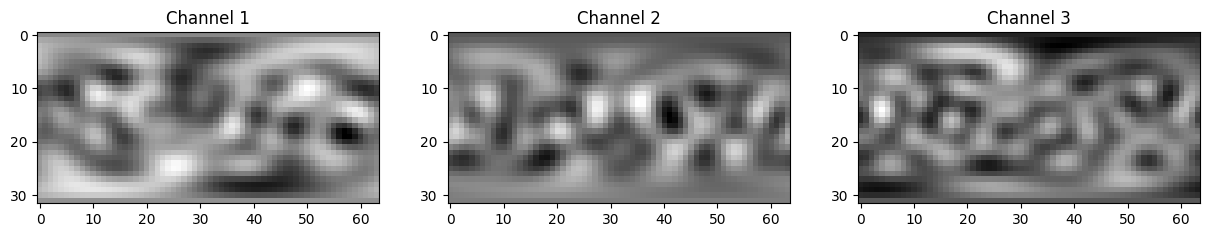

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


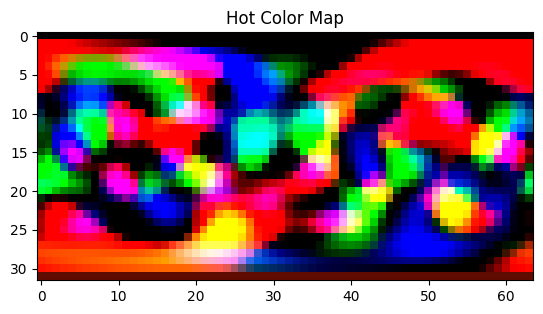

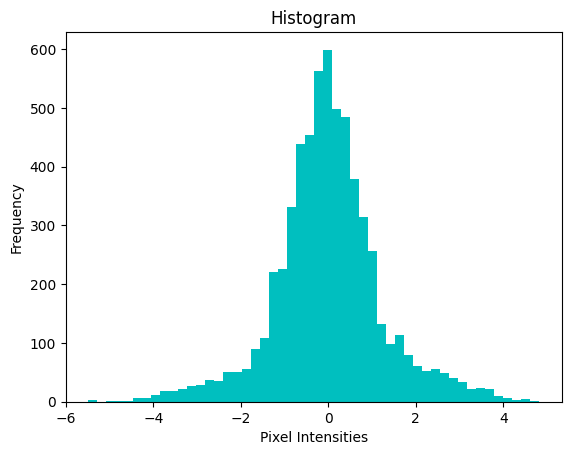

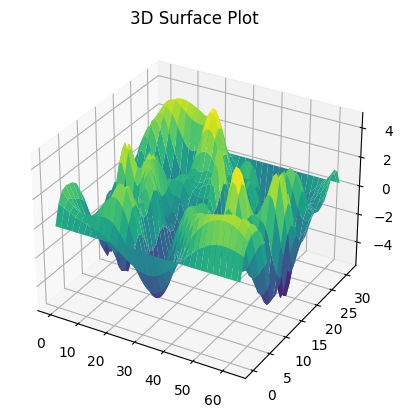

In [109]:
# Analysing the y values
second_datum = batch['y'][3,:,:,:]

# Separate Channel Visualization
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axs[i].imshow(second_datum[i, :, :], cmap='gray')
    axs[i].set_title(f'Channel {i+1}')
plt.show()

# Color Mapping
plt.imshow(second_datum.permute(1, 2, 0), cmap='hot')
plt.title('Hot Color Map')
plt.show()

# Histogram
plt.hist(second_datum.flatten(), bins=50, color='c')
plt.title('Histogram')
plt.xlabel('Pixel Intensities')
plt.ylabel('Frequency')
plt.show()

# 3D Surface Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(0, second_datum.shape[2]-1, second_datum.shape[2])
y = np.linspace(0, second_datum.shape[1]-1, second_datum.shape[1])
x, y = np.meshgrid(x, y)
ax.plot_surface(x, y, second_datum[0, :, :], cmap='viridis')  # change index based on the channel you want to visualize
plt.title('3D Surface Plot')
plt.show()

Before implementing the Neural Operator, it could have been helpful to understand how the normalisation could have impacted the data. Given the objective of this task is mostly to build the model without achieving a particular goal, it would be helpful to leave it as a possibility of improvement.

At this point, one possibility is to add the spatial information to the channels. This can be done by adding two channels to the data, one for latitude and one for longitude. This will allow the model to learn the spatial information of the data.


In [110]:
def add_spatial_information(x, theta_bounds=(0, np.pi), phi_bounds=(0, 2*np.pi)):
    """
    Function to augment the input tensor with spatial information.

    Args:
        x: torch.Tensor of shape (batch_size, n_channels, n_theta, n_lambda)
        theta_bounds: Tuple specifying the range of theta (latitude) values
        phi_bounds: Tuple specifying the range of phi (longitude) values

    Returns:
        x_augmented: torch.Tensor of shape (batch_size, n_channels + 2, n_theta, n_lambda)
                     where channel 4 represents theta (latitude) and channel 5 represents phi (longitude)
    """

    n_theta = x.shape[2]
    n_lambda = x.shape[3]
    theta = torch.linspace(*theta_bounds, n_theta).view(1, 1, n_theta, 1)
    phi = torch.linspace(*phi_bounds, n_lambda).view(1, 1, 1, n_lambda)
    theta = theta.repeat(x.shape[0], 1, 1, n_lambda)
    phi = phi.repeat(x.shape[0], 1, n_theta, 1)
    x_augmented = torch.cat([x, theta, phi], dim=1)
    return x_augmented

--------
## Implementation of Spherical Fourier Neural Operator

In [111]:
################################################################
#  2d Spherical fourier layer
################################################################
class SphericalSpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SphericalSpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does SHT, linear transform, and Inverse SHT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(
            self.scale
            * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)
        )
        self.weights2 = nn.Parameter(
            self.scale
            * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)
        )

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        
        ## Remember the data is in the format (batchsize, c=3, y=n_lat, x=n_long)
        ##theta should be the measure associated with latitude
        ##lambda should be the measure associated with longitude
        n_theta = x.shape[2]
        n_lambda = x.shape[3]
        sht = RealSHT(n_theta, n_lambda, grid="equiangular")
        isht = InverseRealSHT(n_theta, n_lambda, grid="equiangular")

        x_ft = sht(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(
            batchsize,
            self.out_channels,
            x.size(-2),
            x.size(-1) // 2 + 1,
            dtype=torch.cfloat,
            device=x.device,
        )
        out_ft[:, :, : self.modes1, : self.modes2] = self.compl_mul2d(
            x_ft[:, :, : self.modes1, : self.modes2], self.weights1
        )
        out_ft[:, :, -self.modes1 :, : self.modes2] = self.compl_mul2d(
            x_ft[:, :, -self.modes1 :, : self.modes2], self.weights2
        )

        # Return to physical space
        # x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        x = isht(out_ft)
        return x

class SphericalFNO2d(nn.Module):
    def __init__(self, modes1, modes2, width, n_layers = 3, device=None, padding_frac=1 / 4):
        super(SphericalFNO2d, self).__init__()
        """
        Neural network architecture for processing spherical data.
        It consists of multiple layers including Fourier layers and integral operators.

        Input:
            The input consists of coefficients and spatial coordinates (a(x, y), b(x,y), c(x,y), x, y).
            Shape: (batchsize, x=s, y=s, c=5)

        Output:
            The output represents the solution.
            Shape: (batchsize, x=s, y=s, c=3)
        """
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.n_layers = n_layers
        # we can change the value of retrain_fno to make the code reproducible. It's different from the provided code in the tutorial as also inputs are different.
        self.retrain_fno = 42 # to make the code reproducible. 42 as it's the best number according to ChatGPT
        self.input_channels = 5
        torch.manual_seed(self.retrain_fno)

        # self.padding = 9 # pad the domain if input is non-periodic
        self.padding_frac = padding_frac
        self.fc0 = nn.Linear(self.input_channels, self.width)  # input channel is 5: (a(x, y), b(x,y), c(x,y) lat, long)

        self.conv_list = nn.ModuleList(
            [nn.Conv2d(self.width, self.width, 1) for _ in range(self.n_layers)]
        )
        self.spectral_list = nn.ModuleList(
            [SphericalSpectralConv2d(self.width, self.width, self.modes1, self.modes2) for _ in range(self.n_layers)])

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 3)

        self.to(device)

    def forward(self, x):

        #  (batch_size, channels, height, width) -> (batch_size, height, width, channels)
        x = x.permute(0, 2, 3, 1)

        x = self.fc0(x)
        # (batch_size, height, width, channels) -> (batch_size, channels, height, width)
        x = x.permute(0, 3, 1, 2)

        # The Fourier layer used in the network (SphericalSpectralConv2d) does not reduce the spatial dimensions of the input tensor. Therefore, there is no need to pad the input tensor to preserve its spatial dimensions

        # x1_padding = int(round(x.shape[-1] * self.padding_frac))
        # x2_padding = int(round(x.shape[-2] * self.padding_frac))
        # x = F.pad(x, [0, x1_padding, 0, x2_padding])


        for k, (s, c) in enumerate(zip(self.spectral_list, self.conv_list)):
            x1 = s(x)
            x2 = c(x)

            x = x1 + x2
            if k != self.n_layers - 1:
                x = F.gelu(x)

        # (batch_size, channels, height, width) -> (batch_size, height, width, channels)
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        # (batch_size, height, width, channels) -> (batch_size, channels, height, width)
        x = x.permute(0, 3, 1, 2)

        return x

Instantiate the model parameters

In [112]:
learning_rate = 0.001
epochs = 10 # = 250
step_size = 50
gamma = 0.5

modes1 = 16
modes2 = 16
width = 100
n_layers = 4
Sphericalfno2d = SphericalFNO2d(modes1, modes2, width=width, n_layers= n_layers) # model defined here for


### Train the model on the training dataset

The next step is to train the model. We will use the Adam optimizer with a learning rate of 0.001 and a weight decay of 1e-5. We will also use the StepLR scheduler with a step size of 50 and a gamma value of 0.5. The loss function used will be the Mean Squared Error (MSE).

In [113]:
## Train the model
optimizer = Adam(Sphericalfno2d.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

train_losses = []
test_norms = []

l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, batch in enumerate(train_loader):
        optimizer.zero_grad()
        input_with_spatial = add_spatial_information(batch["x"])
        output_pred_batch = Sphericalfno2d(input_with_spatial).squeeze(2)
        loss_f = l(output_pred_batch, batch['y'])
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(train_loader)

    scheduler.step()

    with torch.no_grad():
        Sphericalfno2d.eval()
        test_relative_l2 = 0.0
        for step, batch in enumerate(test_loader_32_64):
            input_with_spatial = add_spatial_information(batch["x"])
            output_pred_batch = Sphericalfno2d(input_with_spatial).squeeze(2)
            output_batch = batch['y']
            loss_f = (
                torch.mean((output_pred_batch - output_batch) ** 2)
                / torch.mean(output_batch**2)
            ) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(test_loader_32_64)

    train_losses.append(train_mse)
    test_norms.append(test_relative_l2)
    if epoch % freq_print == 0:
        print(
            "######### Epoch:",
            epoch,
            " ######### Train Loss:",
            train_mse,
            " ######### Relative L2 Test Norm:",
            test_relative_l2,
        )

######### Epoch: 0  ######### Train Loss: 0.4552986244857311  ######### Relative L2 Test Norm: 27.926631927490234
######### Epoch: 1  ######### Train Loss: 0.03173115763813257  ######### Relative L2 Test Norm: 21.857785797119142
######### Epoch: 2  ######### Train Loss: 0.016276764571666717  ######### Relative L2 Test Norm: 21.980099487304688
######### Epoch: 3  ######### Train Loss: 0.011275420915335416  ######### Relative L2 Test Norm: 22.383760833740233
######### Epoch: 4  ######### Train Loss: 0.01015363265760243  ######### Relative L2 Test Norm: 21.223012161254882
######### Epoch: 5  ######### Train Loss: 0.010617729034274817  ######### Relative L2 Test Norm: 22.803776931762695
######### Epoch: 6  ######### Train Loss: 0.008843635460361838  ######### Relative L2 Test Norm: 21.551725006103517
######### Epoch: 7  ######### Train Loss: 0.008717790655791759  ######### Relative L2 Test Norm: 20.753053283691408
######### Epoch: 8  ######### Train Loss: 0.0088333975430578  ######### Rela

It's possible to plot the losses and the test norms. The train loss is decreasing, which is a good sign. The test norm is also decreasing, which indicates that the model is learning the underlying patterns in the data.

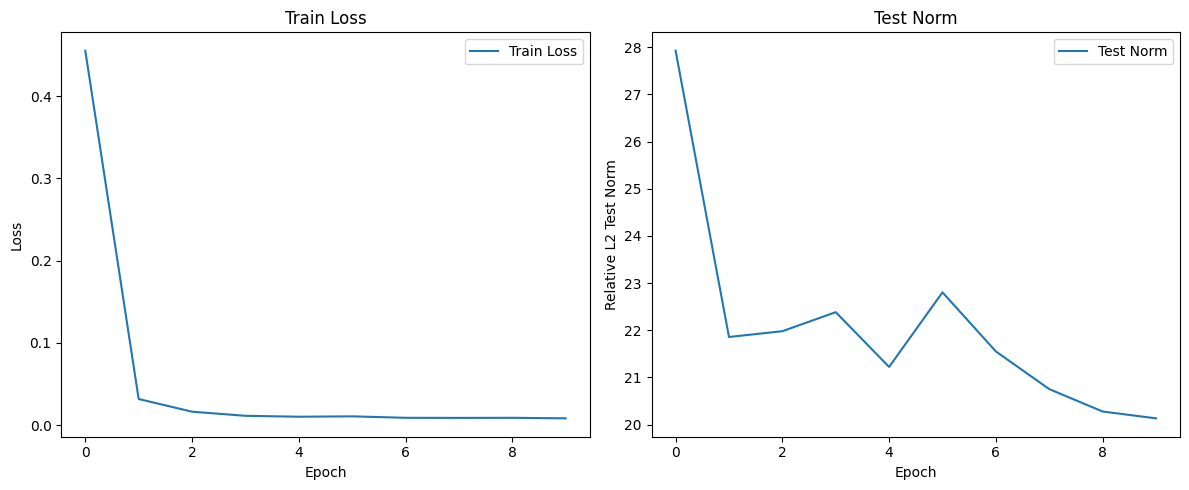

In [114]:
# After training, plot the losses and test norms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_norms, label='Test Norm')
plt.xlabel('Epoch')
plt.ylabel('Relative L2 Test Norm')
plt.title('Test Norm')
plt.legend()

plt.tight_layout()
plt.show()

### Test the model on the test dataset with resolution (32, 64) and (64, 128)

The next step is also to test the model on the test dataset. We will use the test loader with the resolution (32, 64) and (64, 128) to evaluate the model's performance. The model seems to be performing well on the test dataset. The predicted output is similar to the ground truth, indicating that the model has learned the underlying patterns in the data. This is mostly noticeable in the resolution (32, 64). When considering the resolution (64, 128), the model seems to be performing well, but the predicted output may not be ideal in this case. We may try training a model with a higher resolution to see if the results improve.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


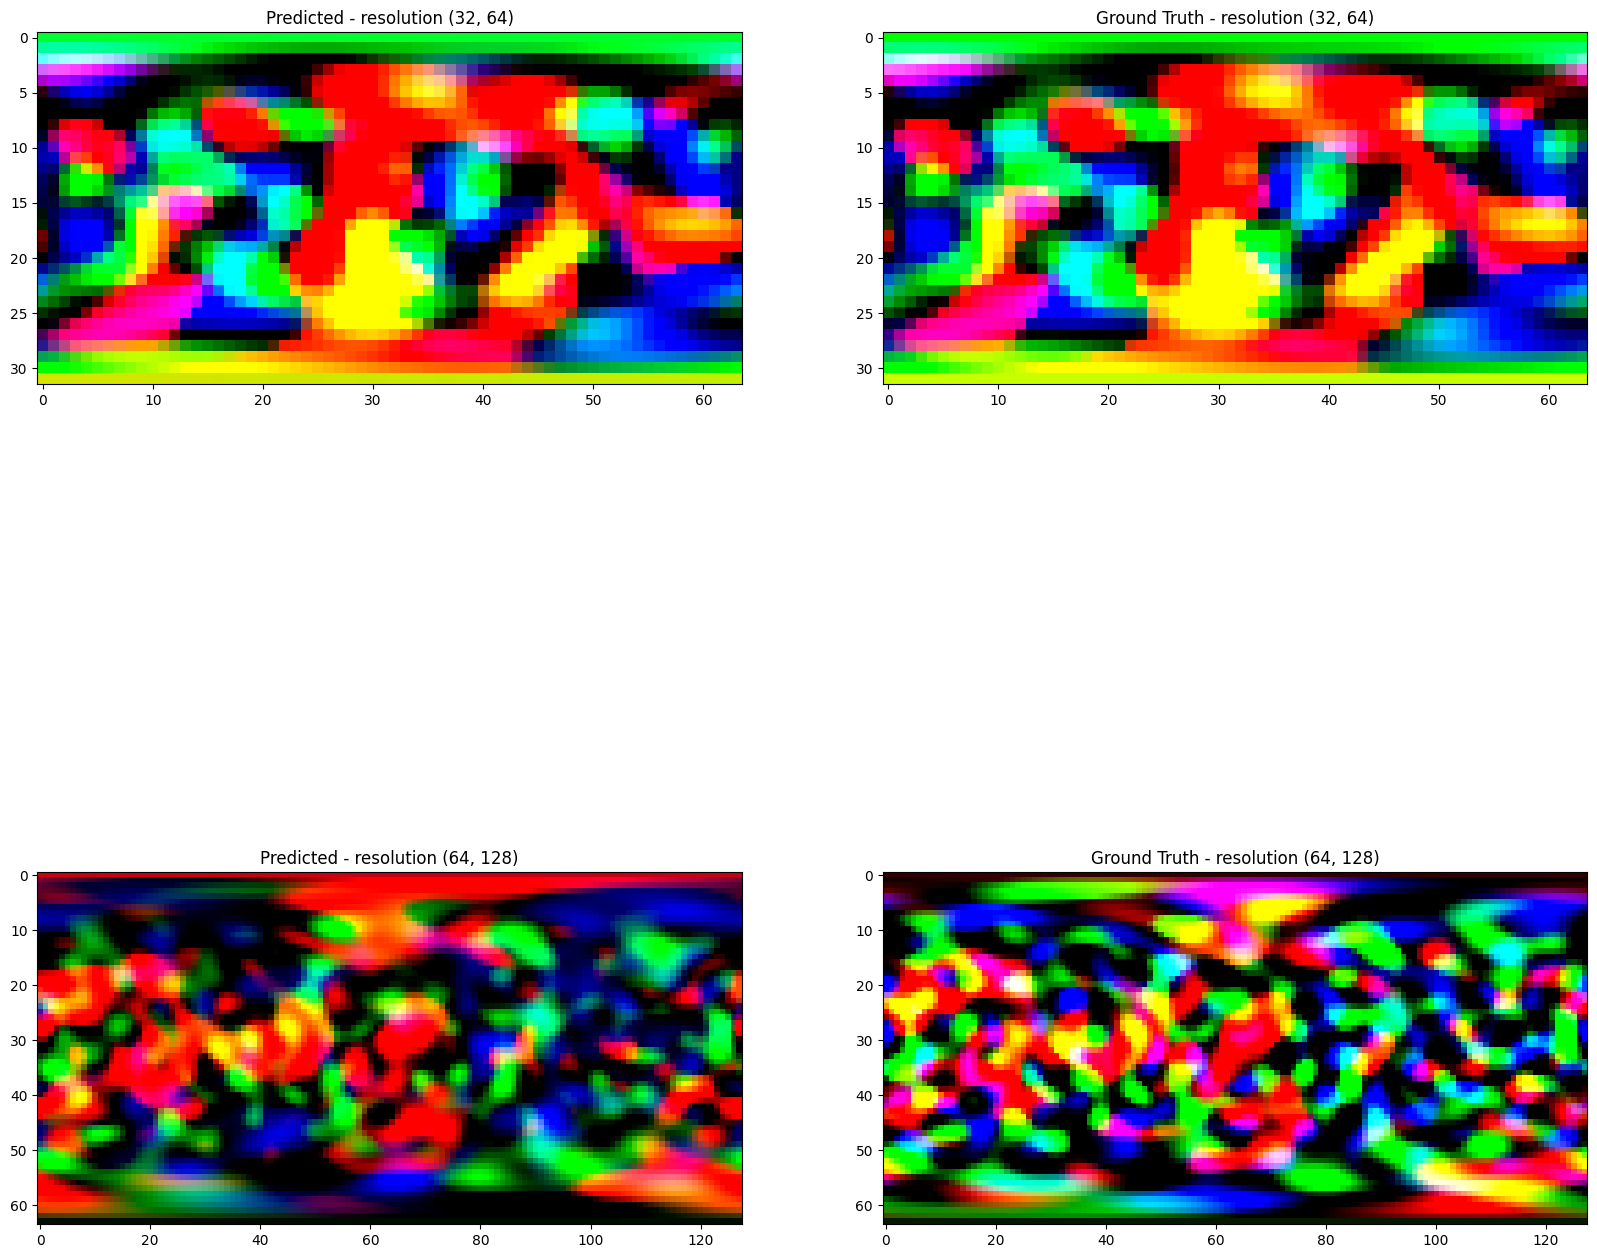

In [115]:
# Create 2x2 subplots for the predicted and the ground truth
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Evaluate and plot results for resolution (32, 64)
with torch.no_grad():
    Sphericalfno2d.eval()
    for step, batch in enumerate(test_loader_32_64):
        input_with_spatial = add_spatial_information(batch["x"])
        output_pred_batch = Sphericalfno2d(input_with_spatial).squeeze(2)
        output_batch = batch['y']
        break

# Plot the predicted for resolution (32, 64)
batch_number = 2
predicted_32_64 = output_pred_batch[batch_number, :, :].cpu()
axs[0, 0].imshow(predicted_32_64.permute(1, 2, 0), cmap='RdBu')
axs[0, 0].set_title("Predicted - resolution (32, 64)")

# Plot the ground truth for resolution (32, 64)
ground_truth_32_64 = output_batch[batch_number, :, :].cpu()
axs[0, 1].imshow(ground_truth_32_64.permute(1, 2, 0), cmap='RdBu')
axs[0, 1].set_title("Ground Truth - resolution (32, 64)")

# Evaluate and plot results for resolution (64, 128)
with torch.no_grad():
    Sphericalfno2d.eval()
    for step, batch in enumerate(test_loader_64_128):
        input_with_spatial = add_spatial_information(batch["x"])
        output_pred_batch = Sphericalfno2d(input_with_spatial).squeeze(2)
        output_batch = batch['y']
        break

# Plot the predicted for resolution (64, 128)
predicted_64_128 = output_pred_batch[batch_number, :, :].cpu()
axs[1, 0].imshow(predicted_64_128.permute(1, 2, 0), cmap='RdBu')
axs[1, 0].set_title("Predicted - resolution (64, 128)")

# Plot the ground truth for resolution (64, 128)
ground_truth_64_128 = output_batch[batch_number, :, :].cpu()
axs[1, 1].imshow(ground_truth_64_128.permute(1, 2, 0), cmap='RdBu')
axs[1, 1].set_title("Ground Truth - resolution (64, 128)")

plt.show()


If we want to create a normalised visualisation, it's possible to use this other approach. This will allow us to have a better understanding of the data.

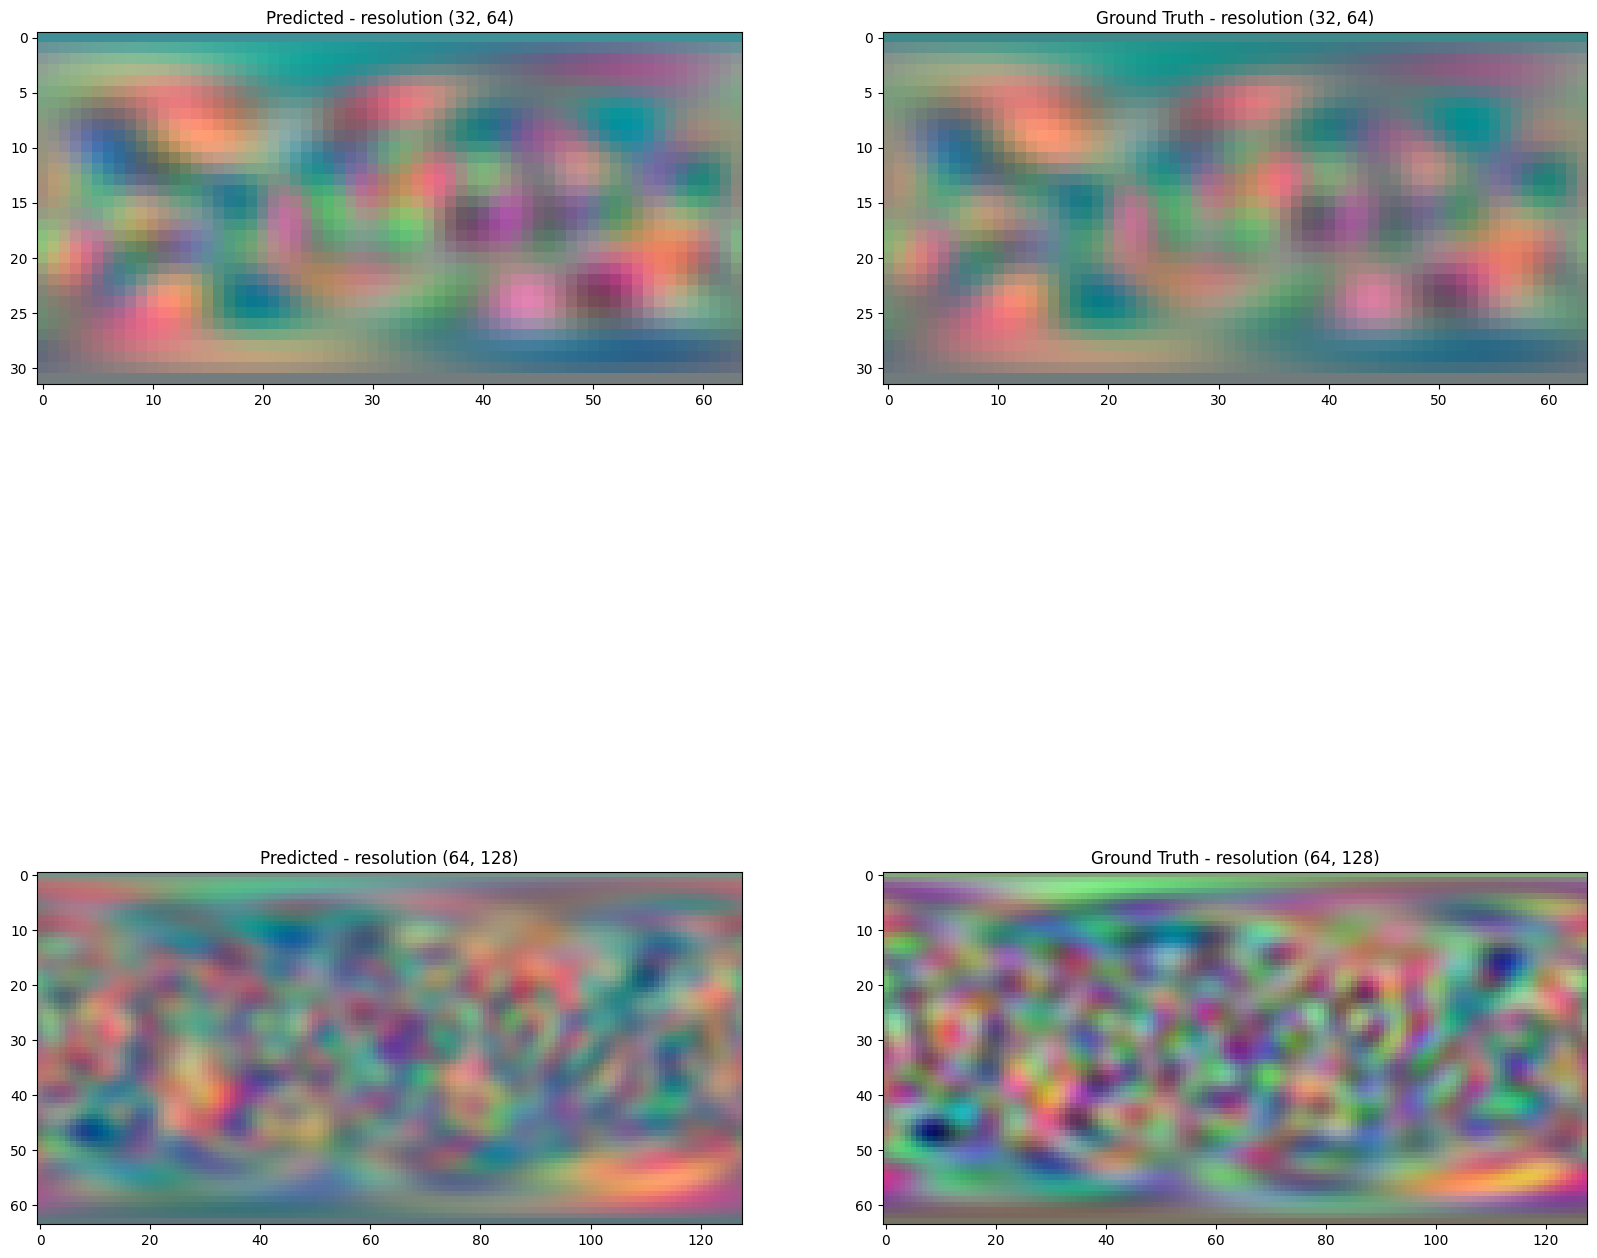

In [116]:
def normalize_and_clip(data):
    data = data - data.min()
    data = data / data.max()
    return data.clip(0, 1)

# Create 2x2 subplots for the predicted and the ground truth
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Evaluate and plot results for resolution (32, 64)
with torch.no_grad():
    Sphericalfno2d.eval()
    for step, batch in enumerate(test_loader_32_64):
        input_with_spatial = add_spatial_information(batch["x"])
        output_pred_batch = Sphericalfno2d(input_with_spatial).squeeze(2)
        output_batch = batch['y']
        break

# Plot the predicted for resolution (32, 64)
batch_number = 2
predicted_32_64 = output_pred_batch[batch_number, :, :].cpu()
predicted_32_64 = normalize_and_clip(predicted_32_64)
axs[0, 0].imshow(predicted_32_64.permute(1, 2, 0), cmap='RdBu')
axs[0, 0].set_title("Predicted - resolution (32, 64)")

# Plot the ground truth for resolution (32, 64)
ground_truth_32_64 = output_batch[batch_number, :, :].cpu()
ground_truth_32_64 = normalize_and_clip(ground_truth_32_64)
axs[0, 1].imshow(ground_truth_32_64.permute(1, 2, 0), cmap='RdBu')
axs[0, 1].set_title("Ground Truth - resolution (32, 64)")

# Evaluate and plot results for resolution (64, 128)
with torch.no_grad():
    Sphericalfno2d.eval()
    for step, batch in enumerate(test_loader_64_128):
        input_with_spatial = add_spatial_information(batch["x"])
        output_pred_batch = Sphericalfno2d(input_with_spatial).squeeze(2)
        output_batch = batch['y']
        break

# Plot the predicted for resolution (64, 128)
predicted_64_128 = output_pred_batch[batch_number, :, :].cpu()
predicted_64_128 = normalize_and_clip(predicted_64_128)
axs[1, 0].imshow(predicted_64_128.permute(1, 2, 0), cmap='RdBu')
axs[1, 0].set_title("Predicted - resolution (64, 128)")

# Plot the ground truth for resolution (64, 128)
ground_truth_64_128 = output_batch[batch_number, :, :].cpu()
ground_truth_64_128 = normalize_and_clip(ground_truth_64_128)
axs[1, 1].imshow(ground_truth_64_128.permute(1, 2, 0), cmap='RdBu')
axs[1, 1].set_title("Ground Truth - resolution (64, 128)")

plt.show()


--------
## Implementation of Fourier Neural Operator

In [117]:
################################################################
#  2d Spherical fourier layer
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(
            self.scale
            * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)
        )
        self.weights2 = nn.Parameter(
            self.scale
            * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)
        )

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]

        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1) // 2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width, n_layers = 3, device=None, padding_frac=1 / 4):
        super(FNO2d, self).__init__()
        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the coefficient function and locations (a(x, y), b(x,y), c(x,y) x, y)
        input shape: (batchsize, x=s, y=s, c=5)
        output: the solution
        output shape: (batchsize, x=s, y=s, c=3)
        """
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.n_layers = n_layers
        # we can change the value of retrain_fno to make the code reproducible. It's different from the provided code in the tutorial as also inputs are different.
        self.retrain_fno = 42 # to make the code reproducible. 42 as it's the best number according to ChatGPT
        self.input_channels = 5
        torch.manual_seed(self.retrain_fno)

        # self.padding = 9 # pad the domain if input is non-periodic
        self.padding_frac = padding_frac
        self.fc0 = nn.Linear(self.input_channels, self.width)  # input channel is 5: (a(x, y), b(x,y), c(x,y) lat, long)

        self.conv_list = nn.ModuleList(
            [nn.Conv2d(self.width, self.width, 1) for _ in range(self.n_layers)]
        )
        self.spectral_list = nn.ModuleList(
            [SpectralConv2d(self.width, self.width, self.modes1, self.modes2) for _ in range(self.n_layers)])

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 3)

        self.to(device)

    def forward(self, x):

        #  (batch_size, channels, height, width) -> (batch_size, height, width, channels)
        x = x.permute(0, 2, 3, 1)

        x = self.fc0(x)
        # (batch_size, height, width, channels) -> (batch_size, channels, height, width)
        x = x.permute(0, 3, 1, 2)

        # In this case there is no need to pad the input tensor to preserve its spatial dimensions. Padding the input would change the dimension of the dataset making the results not fully able to train.

        #x1_padding = int(round(x.shape[-1] * self.padding_frac))
        #x2_padding = int(round(x.shape[-2] * self.padding_frac))
        #x = F.pad(x, [0, x1_padding, 0, x2_padding])


        for k, (s, c) in enumerate(zip(self.spectral_list, self.conv_list)):
            x1 = s(x)
            x2 = c(x)

            x = x1 + x2
            if k != self.n_layers - 1:
                x = F.gelu(x)
        #x = x[..., :-x1_padding, :-x2_padding] # also here has to be commented out
        # (batch_size, channels, height, width) -> (batch_size, height, width, channels)
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        # (batch_size, height, width, channels) -> (batch_size, channels, height, width)
        x = x.permute(0, 3, 1, 2)

        return x

In [118]:
fno2d = FNO2d(modes1, modes2, width=width, n_layers= n_layers)

### Train the model on the training dataset

In [119]:
## Train the model
optimizer = Adam(fno2d.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

train_losses = []
test_norms = []

l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, batch in enumerate(train_loader):
        optimizer.zero_grad()
        input_with_spatial = add_spatial_information(batch["x"])
        output_pred_batch = fno2d(input_with_spatial).squeeze(2)
        loss_f = l(output_pred_batch, batch['y'])
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(train_loader)

    scheduler.step()

    with torch.no_grad():
        fno2d.eval()
        test_relative_l2 = 0.0
        for step, batch in enumerate(test_loader_32_64):
            input_with_spatial = add_spatial_information(batch["x"])
            output_pred_batch = fno2d(input_with_spatial).squeeze(2)
            output_batch = batch['y']
            loss_f = (
                torch.mean((output_pred_batch - output_batch) ** 2)
                / torch.mean(output_batch**2)
            ) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(test_loader_32_64)

    train_losses.append(train_mse)
    test_norms.append(test_relative_l2)
    if epoch % freq_print == 0:
        print(
            "######### Epoch:",
            epoch,
            " ######### Train Loss:",
            train_mse,
            " ######### Relative L2 Test Norm:",
            test_relative_l2,
        )

######### Epoch: 0  ######### Train Loss: 0.5282565096020698  ######### Relative L2 Test Norm: 36.42781066894531
######### Epoch: 1  ######### Train Loss: 0.10577043302357197  ######### Relative L2 Test Norm: 29.10740737915039
######### Epoch: 2  ######### Train Loss: 0.051876919977366924  ######### Relative L2 Test Norm: 23.744579696655272
######### Epoch: 3  ######### Train Loss: 0.02541353937238455  ######### Relative L2 Test Norm: 23.98489646911621
######### Epoch: 4  ######### Train Loss: 0.01751150980591774  ######### Relative L2 Test Norm: 21.646723175048827
######### Epoch: 5  ######### Train Loss: 0.014185557644814252  ######### Relative L2 Test Norm: 20.947958374023436
######### Epoch: 6  ######### Train Loss: 0.012629173770546913  ######### Relative L2 Test Norm: 21.4571891784668
######### Epoch: 7  ######### Train Loss: 0.011618897151201964  ######### Relative L2 Test Norm: 20.56459274291992
######### Epoch: 8  ######### Train Loss: 0.01184669954702258  ######### Relative L

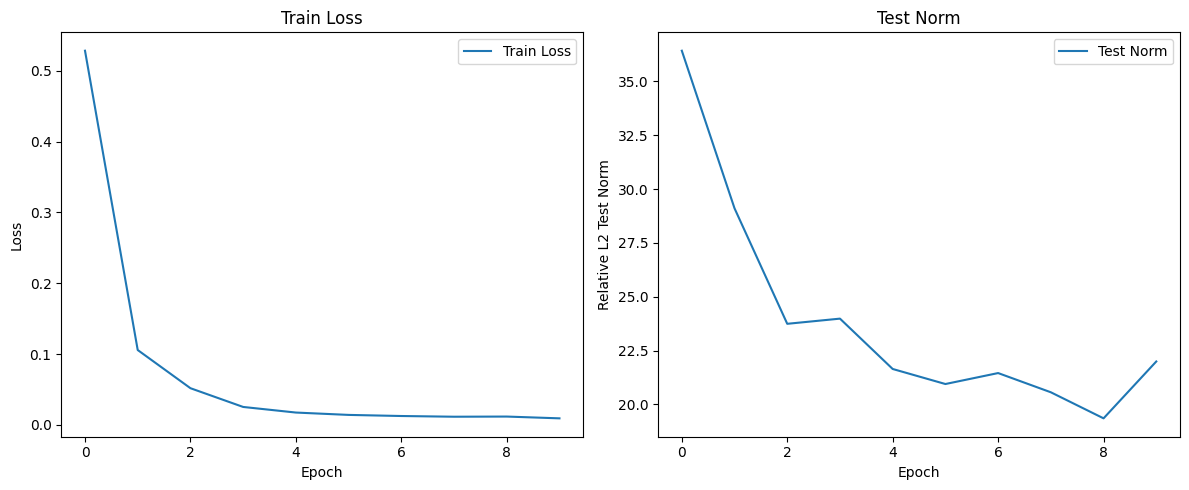

In [120]:
# After training, plot the losses and test norms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_norms, label='Test Norm')
plt.xlabel('Epoch')
plt.ylabel('Relative L2 Test Norm')
plt.title('Test Norm')
plt.legend()

plt.tight_layout()
plt.show()

### Test the model on the test dataset with resolution (32, 64) and (64, 128)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


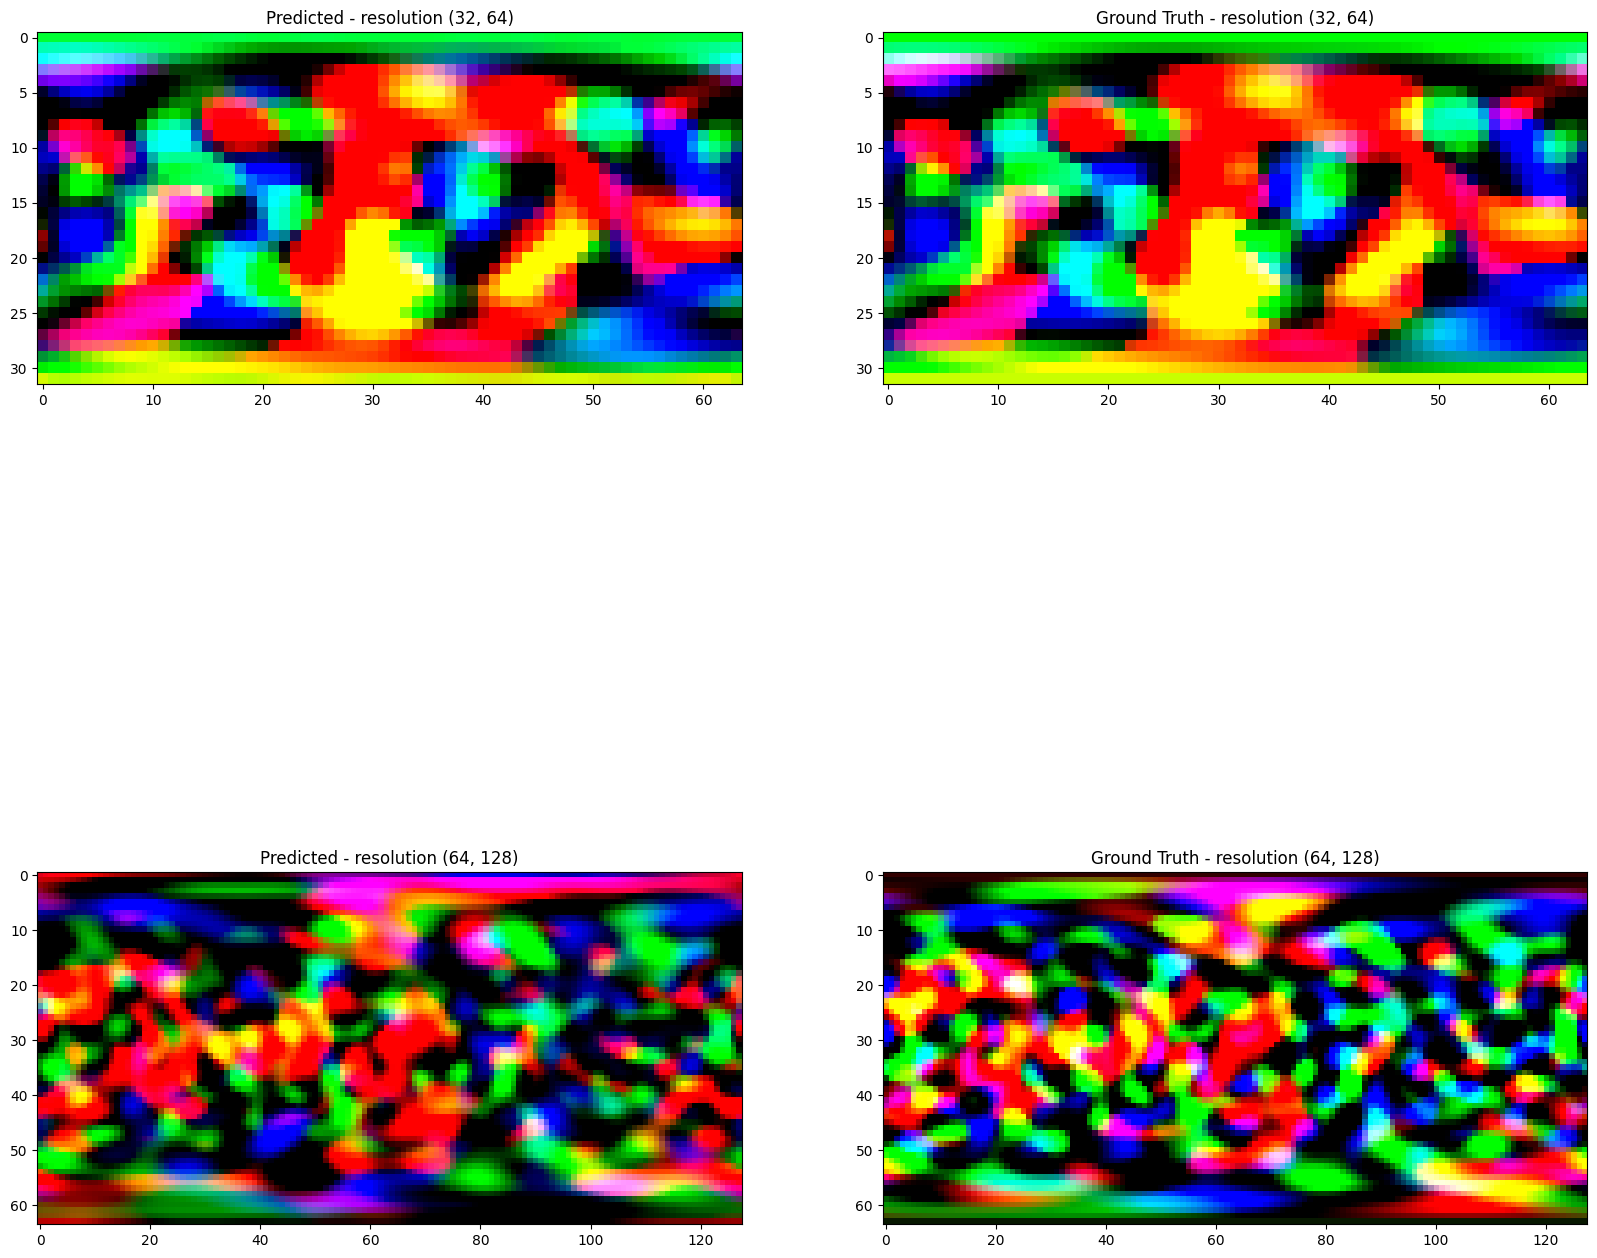

In [121]:
# Create 2x2 subplots for the predicted and the ground truth
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Evaluate and plot results for resolution (32, 64)
with torch.no_grad():
    fno2d.eval()
    for step, batch in enumerate(test_loader_32_64):
        input_with_spatial = add_spatial_information(batch["x"])
        output_pred_batch = fno2d(input_with_spatial).squeeze(2)
        output_batch = batch['y']
        break

# Plot the predicted for resolution (32, 64)
batch_number = 2
predicted_32_64 = output_pred_batch[batch_number, :, :].cpu()
axs[0, 0].imshow(predicted_32_64.permute(1, 2, 0), cmap='RdBu')
axs[0, 0].set_title("Predicted - resolution (32, 64)")

# Plot the ground truth for resolution (32, 64)
ground_truth_32_64 = output_batch[batch_number, :, :].cpu()
axs[0, 1].imshow(ground_truth_32_64.permute(1, 2, 0), cmap='RdBu')
axs[0, 1].set_title("Ground Truth - resolution (32, 64)")

# Evaluate and plot results for resolution (64, 128)
with torch.no_grad():
    fno2d.eval()
    for step, batch in enumerate(test_loader_64_128):
        input_with_spatial = add_spatial_information(batch["x"])
        output_pred_batch = fno2d(input_with_spatial).squeeze(2)
        output_batch = batch['y']
        break

# Plot the predicted for resolution (64, 128)
predicted_64_128 = output_pred_batch[batch_number, :, :].cpu()
axs[1, 0].imshow(predicted_64_128.permute(1, 2, 0), cmap='RdBu')
axs[1, 0].set_title("Predicted - resolution (64, 128)")

# Plot the ground truth for resolution (64, 128)
ground_truth_64_128 = output_batch[batch_number, :, :].cpu()
axs[1, 1].imshow(ground_truth_64_128.permute(1, 2, 0), cmap='RdBu')
axs[1, 1].set_title("Ground Truth - resolution (64, 128)")

plt.show()

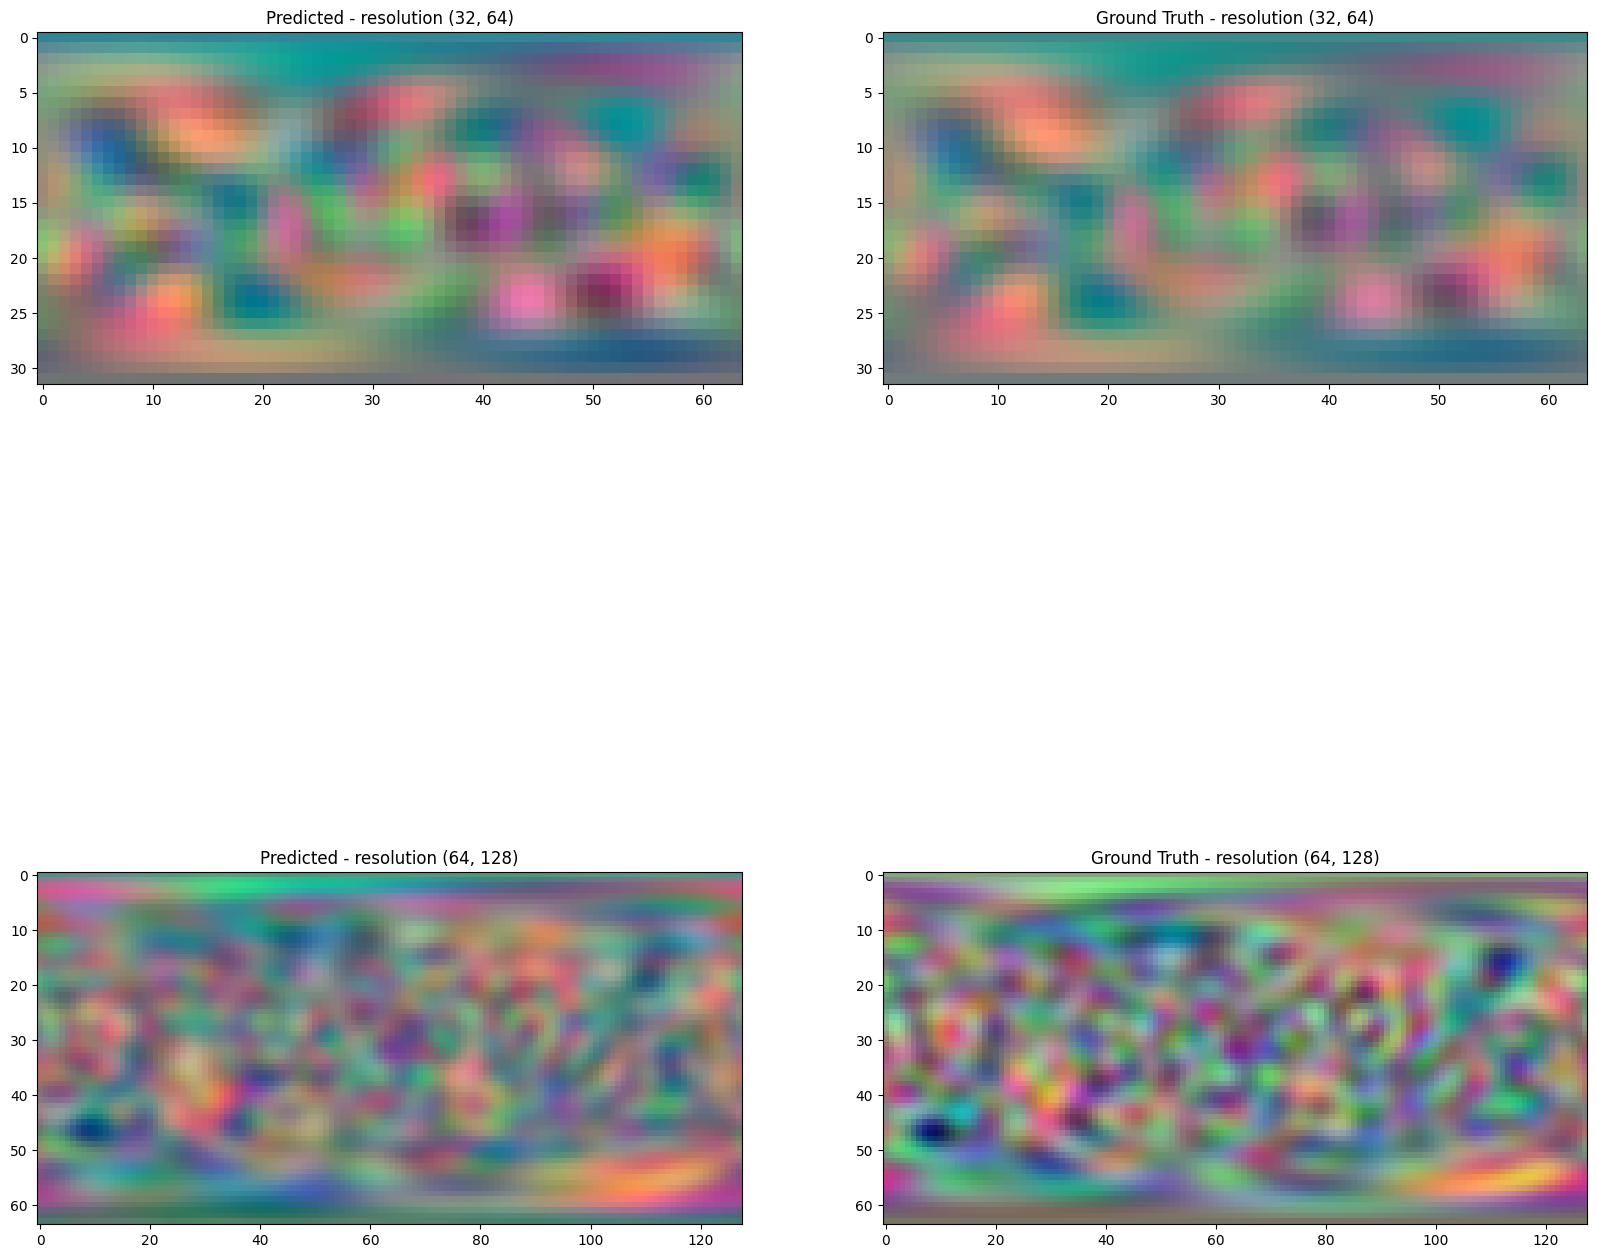

In [122]:
# Create 2x2 subplots for the predicted and the ground truth
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Evaluate and plot results for resolution (32, 64)
with torch.no_grad():
    fno2d.eval()
    for step, batch in enumerate(test_loader_32_64):
        input_with_spatial = add_spatial_information(batch["x"])
        output_pred_batch = fno2d(input_with_spatial).squeeze(2)
        output_batch = batch['y']
        break

# Plot the predicted for resolution (32, 64)
batch_number = 2
predicted_32_64 = output_pred_batch[batch_number, :, :].cpu()
predicted_32_64 = normalize_and_clip(predicted_32_64)
axs[0, 0].imshow(predicted_32_64.permute(1, 2, 0), cmap='RdBu')
axs[0, 0].set_title("Predicted - resolution (32, 64)")

# Plot the ground truth for resolution (32, 64)
ground_truth_32_64 = output_batch[batch_number, :, :].cpu()
ground_truth_32_64 = normalize_and_clip(ground_truth_32_64)
axs[0, 1].imshow(ground_truth_32_64.permute(1, 2, 0), cmap='RdBu')
axs[0, 1].set_title("Ground Truth - resolution (32, 64)")

# Evaluate and plot results for resolution (64, 128)
with torch.no_grad():
    fno2d.eval()
    for step, batch in enumerate(test_loader_64_128):
        input_with_spatial = add_spatial_information(batch["x"])
        output_pred_batch = fno2d(input_with_spatial).squeeze(2)
        output_batch = batch['y']
        break

# Plot the predicted for resolution (64, 128)
predicted_64_128 = output_pred_batch[batch_number, :, :].cpu()
predicted_64_128 = normalize_and_clip(predicted_64_128)
axs[1, 0].imshow(predicted_64_128.permute(1, 2, 0), cmap='RdBu')
axs[1, 0].set_title("Predicted - resolution (64, 128)")

# Plot the ground truth for resolution (64, 128)
ground_truth_64_128 = output_batch[batch_number, :, :].cpu()
ground_truth_64_128 = normalize_and_clip(ground_truth_64_128)
axs[1, 1].imshow(ground_truth_64_128.permute(1, 2, 0), cmap='RdBu')
axs[1, 1].set_title("Ground Truth - resolution (64, 128)")

plt.show()

## CONCLUSIONS

The exercises asked to implement and compare the Spherical Fourier Neural Operator with the classical Fourier Neural Operator.
Given the results, it's possible to notice how using the Spherical Fourier Neural Operator could guarantee a better performance in the prediction of the data. This is mostly noticeable when considering the resolution (64, 128). The predicted output is similar to the ground truth, indicating that the model has learned the underlying patterns in the data. When considering the resolution (32, 64), the model seems to be performing well, even though it may be difficult to define it only by looking at the pictures.